In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy
import os, sys
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
%matplotlib inline

Initial research for a Bayesian fundamental risk premia hedge fund

**Assets Traded**
-----------------
1) Equities
    - Exact breakdown is TBD
    - Categorization will either be by sector (and separated by country), or by Market Cap.
    - Or, and this may be better, by volatiltiy. This allows combining Market Cap. with Sector
    - Securities will be ETFs capturing the relecant market
2) FX
    - Categorized by developed and developing markets
3) Commodities
    - Again captured by ETFs
    - Categorization is up in the air, but potentially by hard/soft commodities
4) Fixed income
    - Natural categorization could be rating
    
**Risk Premia Used**
------------------
1) Momentum
    - Start with SMA crossover
2) Value
3) Carry

**How is this Bayseian?**
-------------------
1) At the most basic level, the idea is to infer a hierarchical regression
    - Returns ~ Indicator*a + B
    - a, B inferred from hierarchy {Asset Type} -> {Categorization} -> {Security}
2) Also interested in inferring parameters for Risk Premia calculations
    -e.g, the exact windows for the moving averages in the momentum calculation

# Step 1:
## Collect data and calculate indicators

*Initial Securities List:
Equities:
- SPY (SP500)
- EFA (Extended developed markets)
- EWJ (Japan)
- FXI (China Large-cap)
- VWO (Emerging Markets)
- IJH (SP500 Mid-cap)
- IJR (SP500 Small-cap)
- IWF (Russell 1000 Growth)
- VIG (Divided Appreciation)


Fixed Income:
- LQD (Investment Grade Corporate)
- HYG (High-yield Coroporate)
- EMB (Emerging Market Debt)
- AGG (US Debt)

Commodities:
- GLD (Gold)
- UCO (Oil)
- JO (Coffee)
- SGG (Sugar)
- PPLT (Platinum)
- VXX (Volatility)

FX:
- UUP (USD)
- FXE (EURO)
- FXB (BPS)
- FXC (CAD)
- FXA (AUD)
- FXY (JPY)
- CEW (Emerging Markets)
- BZF (BRL)

In [2]:
root_dir = os.getcwd()

In [3]:
tickers = dict(
    SPY=dict(asset='equity'),
    EWJ=dict(asset='equity'),
    FXI=dict(asset='equity'),
    EFA=dict(asset='equity'),
    VWO=dict(asset='equity'),
    IJH=dict(asset='equity'),
    IJR=dict(asset='equity'),
    IWF=dict(asset='equity'),
    VIG=dict(asset='equity'),
    LQD=dict(asset='bond'),
    HYG=dict(asset='bond'),
    EMB=dict(asset='bond'),
    AGG=dict(asset='bond'),
    GLD=dict(asset='commodity'),
    UCO=dict(asset='commodity'),
    JO=dict(asset='commodity'),
    SGG=dict(asset='commodity'),
    PPLT=dict(asset='commodity'),
#     VXX=dict(asset='commodity'),
    UUP=dict(asset='fx'),
    FXE=dict(asset='fx'),
    FXB=dict(asset='fx'),
    FXY=dict(asset='fx'),
    CEW=dict(asset='fx'),
    BZF=dict(asset='fx'),
)

In [29]:
def vol_category_helper(row, *args):
    q0, q1, q2 = args[0], args[1], args[2]
    if row <= q0:
        return 0
    elif row <= q1:
        return 1
    elif row <= q2:
        return 2
    else:
        return 3

In [124]:
def corr_helper(row, *args):
    correl = args[0]
    try:
        return correl['SPY'][row.Date][row.ticker]
    except KeyError:
        return np.nan

In [128]:
def beta_helper(row, *args):
    spy = args[0]
    try:
        return (row['corr'] * row['vol']) / spy.loc[row['Date'], 'vol']
    except KeyError:
        return np.nan

In [137]:
def build_prices_dfs(tickers, n_categories=3):
    out = dict()
    for ticker in tickers.keys():
        df = pd.read_csv(root_dir+'/data/{}.csv'.format(ticker))
        df = df.replace({'null': np.nan})
        df['Close'] = pd.to_numeric(df['Close'])
        df['ticker'] = ticker
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date', False)
        df['pct_change'] = pd.to_numeric(df['Close'].pct_change().shift(-1))
        df['log_return'] = (np.log(df.Close) - np.log(df.Close.shift(1))).shift(-1)
        
        # Calculate vol on a 1 year rolling basis
        df['vol'] = df['pct_change'].rolling(252).std()
        df['month_return'] = pd.to_numeric(pd.rolling_sum(df['pct_change'][::-1], window=22, min_periods=22)[::-1])
        df['month_log_return'] = pd.to_numeric(pd.rolling_sum(df['log_return'][::-1], window=22, min_periods=22)[::-1])
        df['asset_type'] = tickers[ticker]['asset']
        out[ticker] = df
    combined = pd.concat([_df for _df in out.values()])
    
    gb_equity = pd.DataFrame()
    for key, grp in combined.groupby('ticker'):
        gb_equity[key] = grp['log_return']
    correl = gb_equity.rolling(252).corr()
    combined['corr'] = combined.apply(corr_helper, axis=1, args=(correl, ))
    combined['beta'] = combined.apply(beta_helper, axis=1, args=(combined.loc[combined.ticker == 'SPY'], ))
    rf = .02 / 252.
    combined['ra_return'] = rf + combined['beta']*(combined['log_return'] - rf)
    for key, grp in combined.groupby('ticker'):
        combined.loc[combined['ticker'] == key, 'ra_month_return'] = pd.rolling_sum(grp['ra_return'][::-1], window=22,
                                                                                    min_periods=22)[::-1]
    q1, q2, q3 = combined['vol'].quantile([.25, .5, .75])
    
    # Equities are placed into 4 vol categories based on their moment-in-time volatility relative to all historical
    # observed vols
    combined['category'] = combined['vol'].apply(vol_category_helper, args=(q1, q2, q3))
    return out, combined
        

In [130]:
prices, combined = build_prices_dfs(tickers, 3)

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,min_periods=22,center=False).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,min_periods=22,center=False).sum()


/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


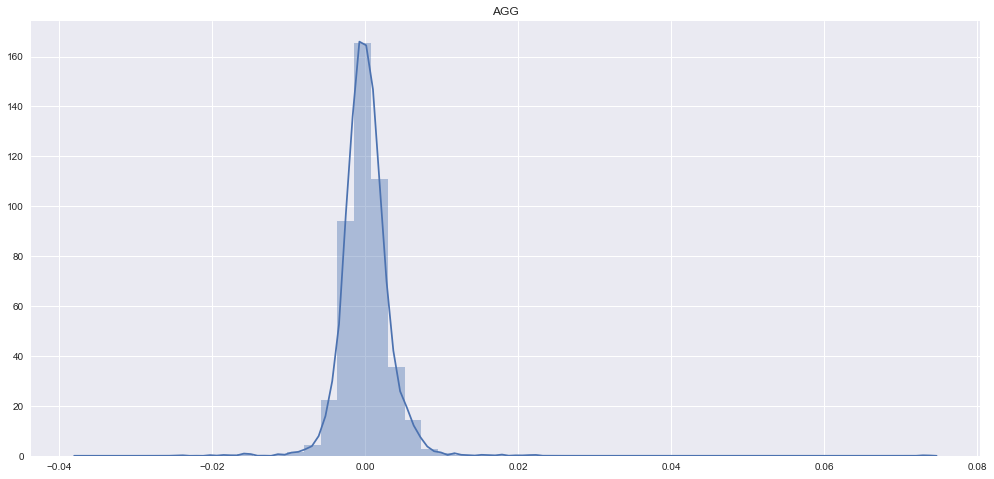

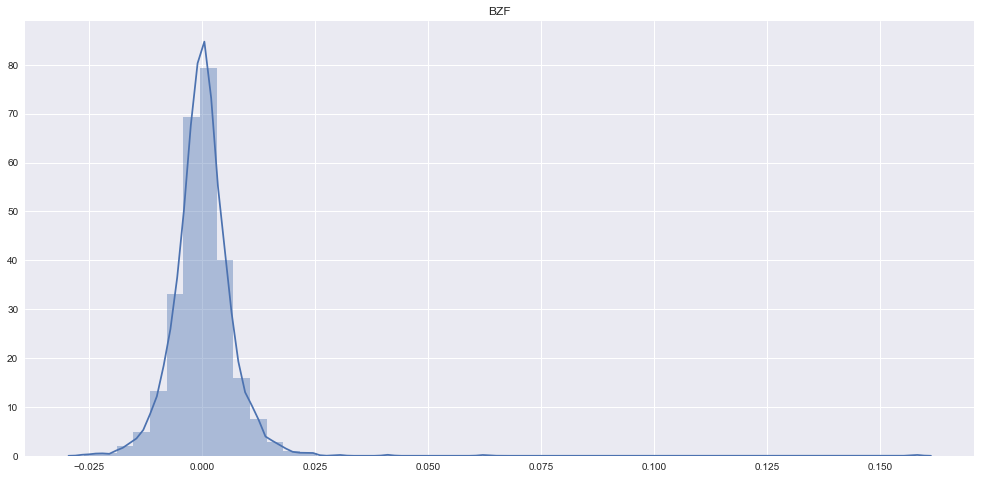

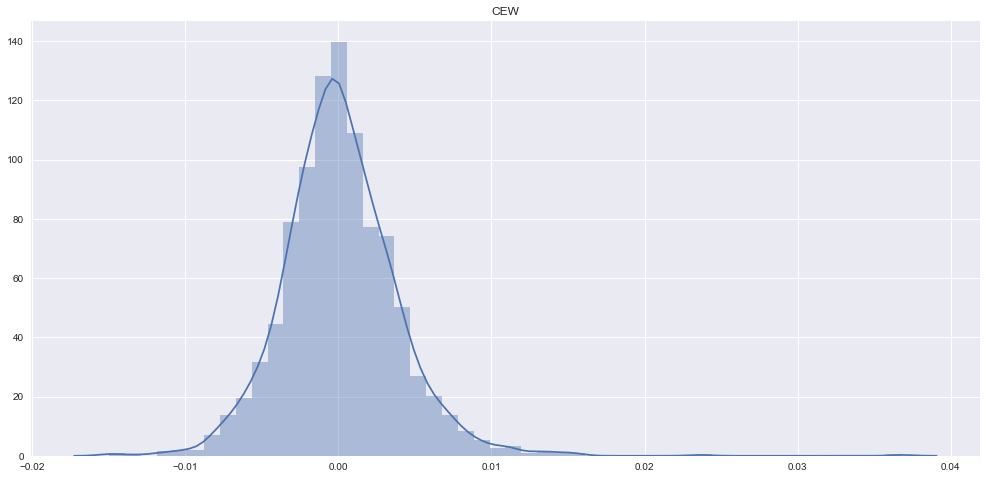

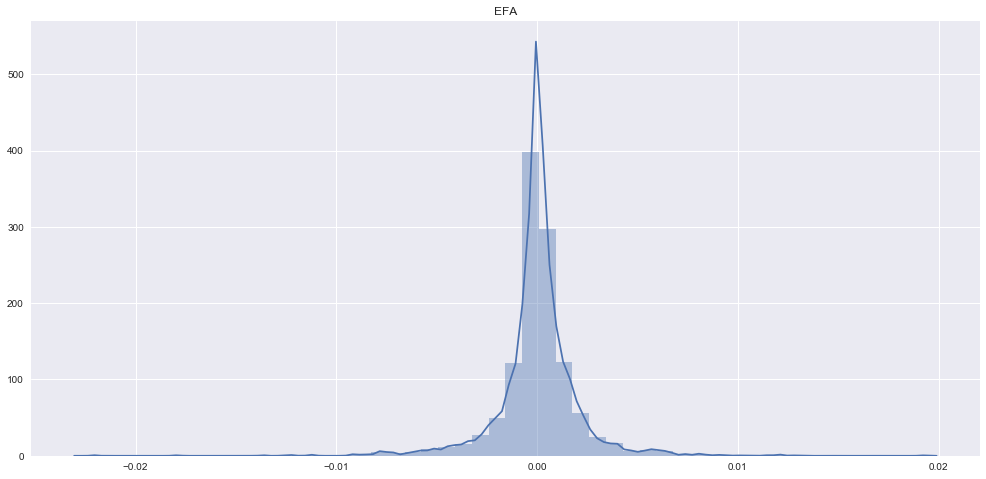

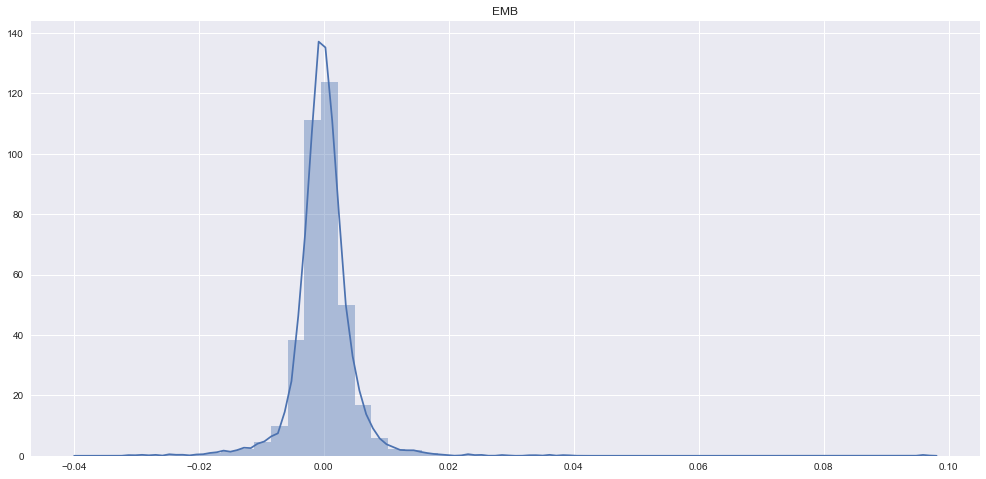

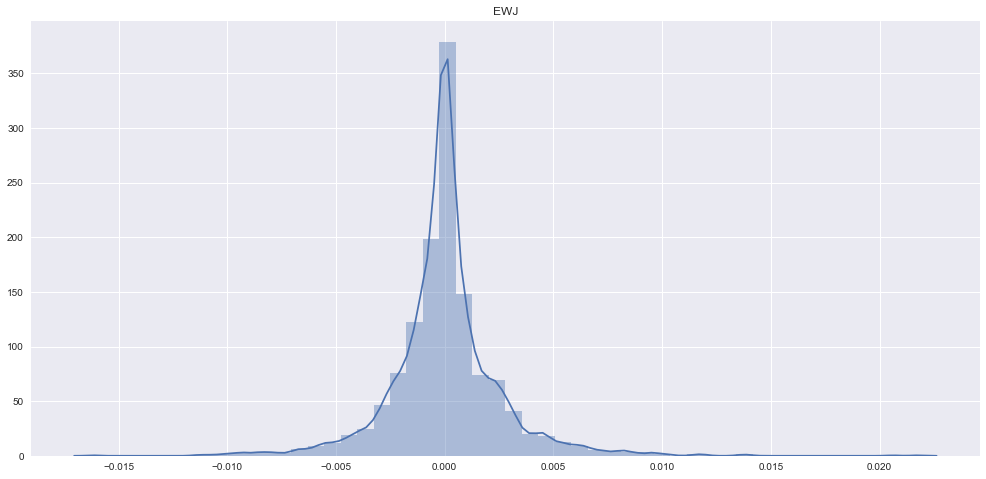

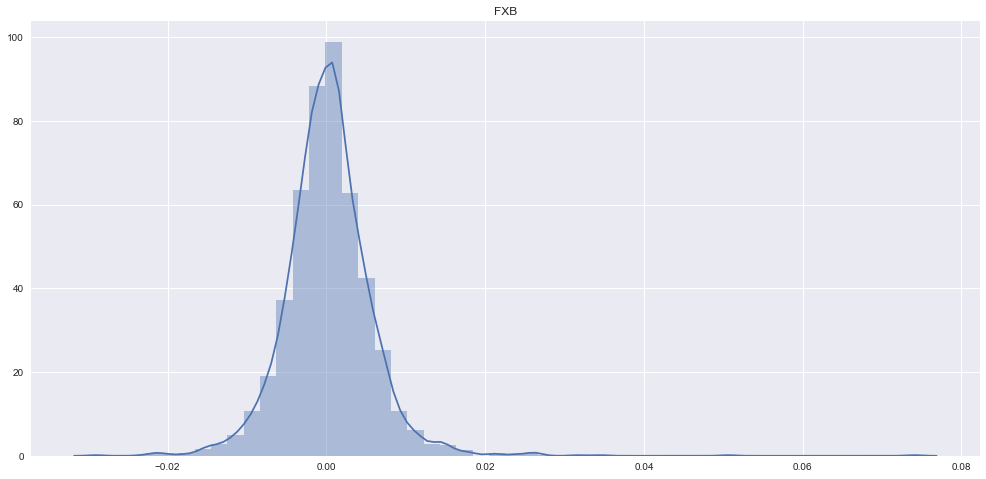

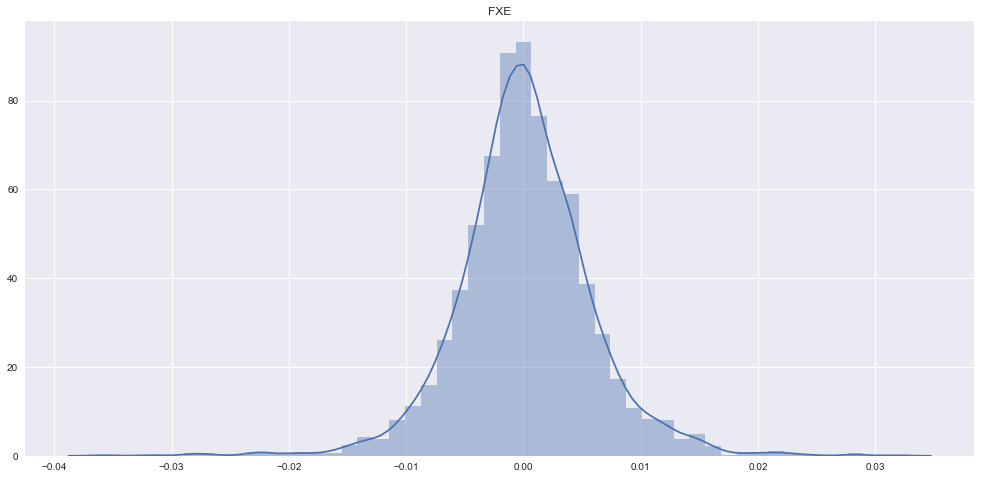

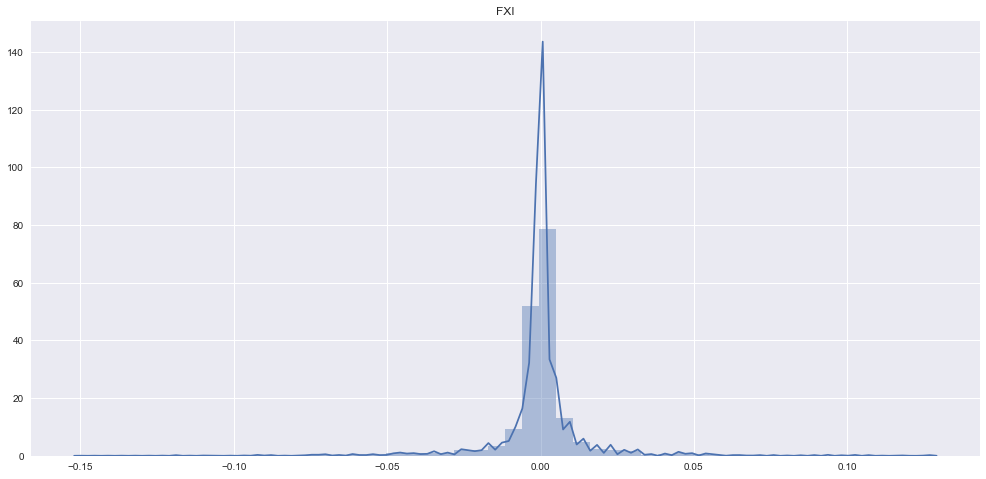

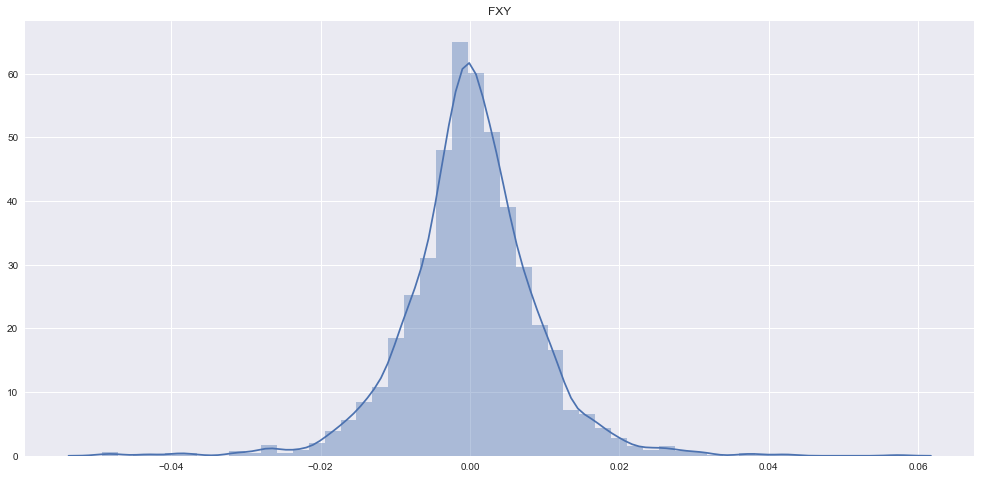

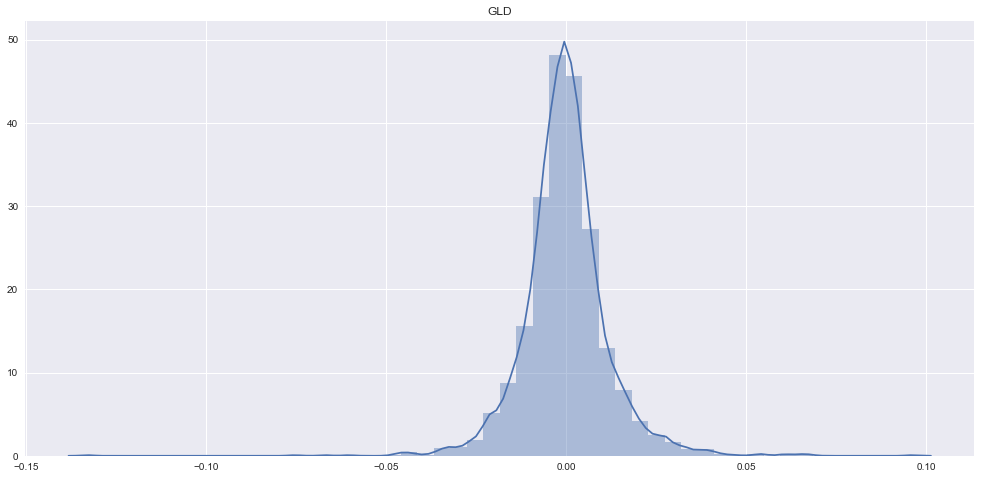

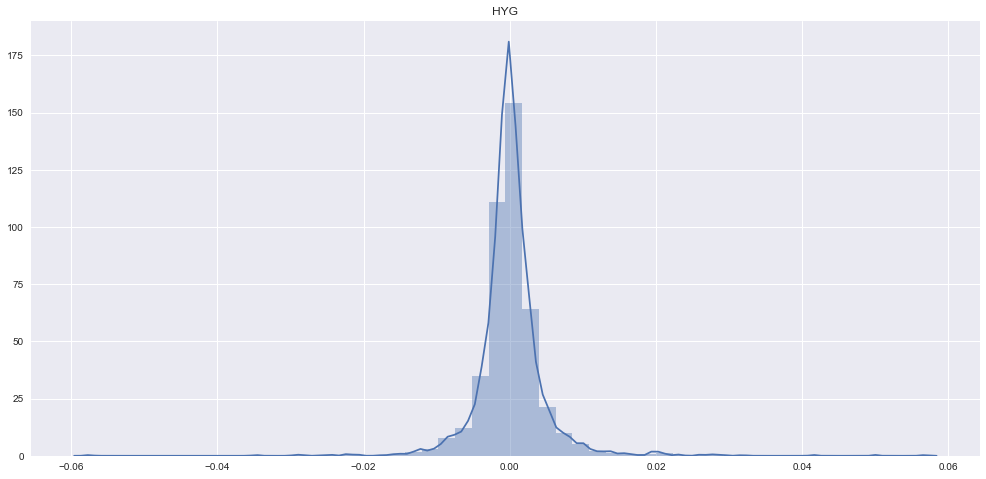

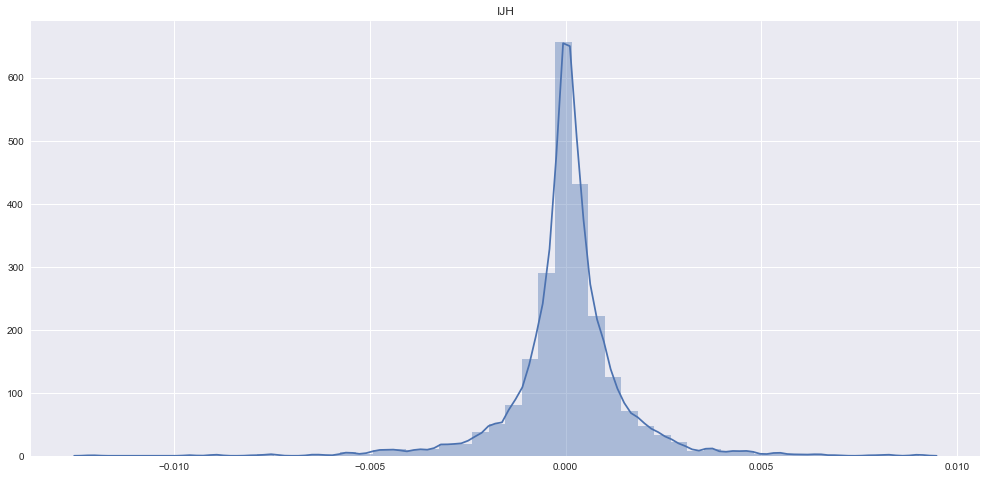

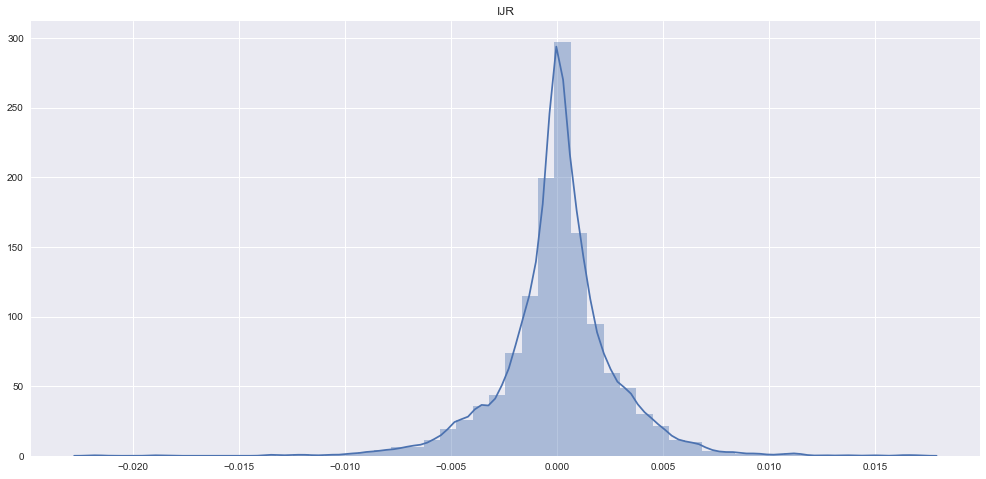

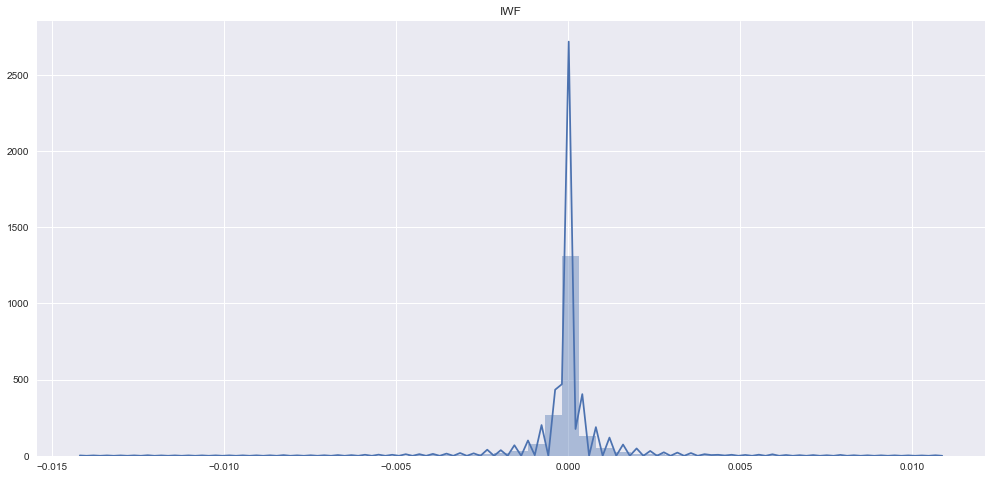

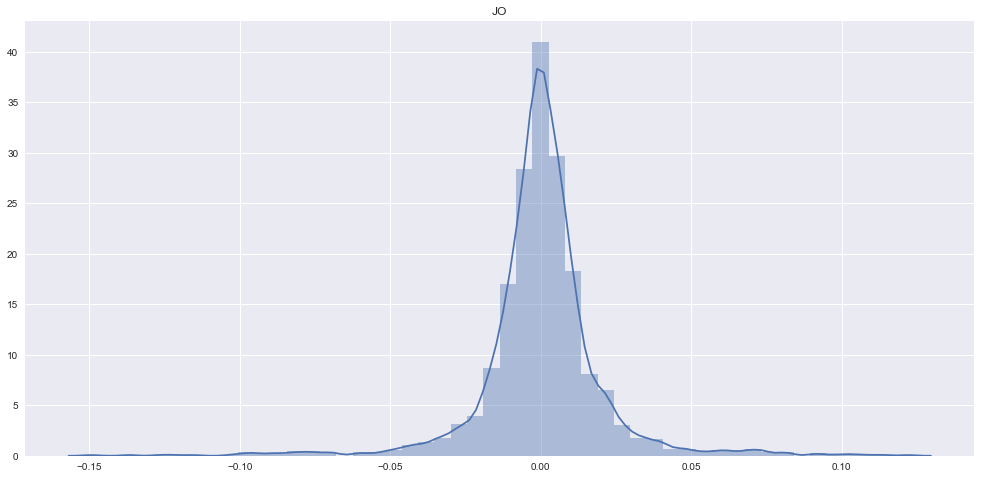

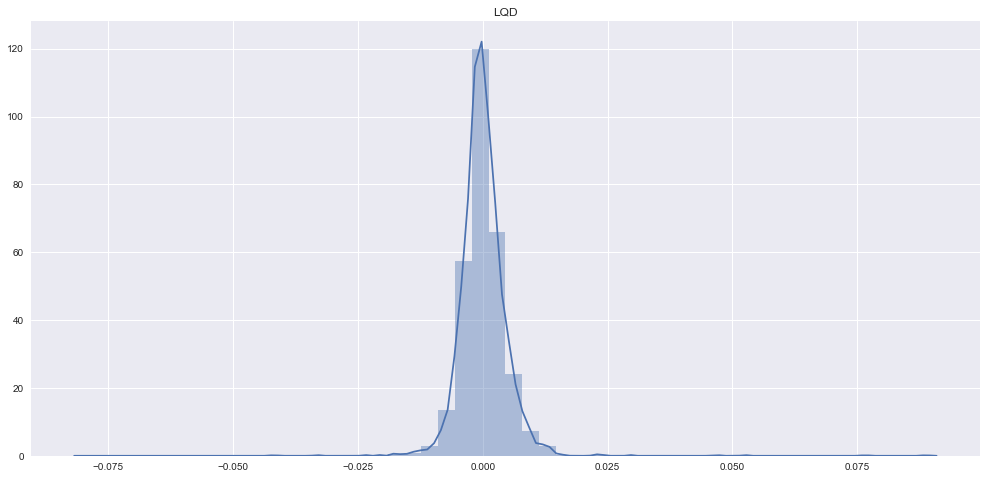

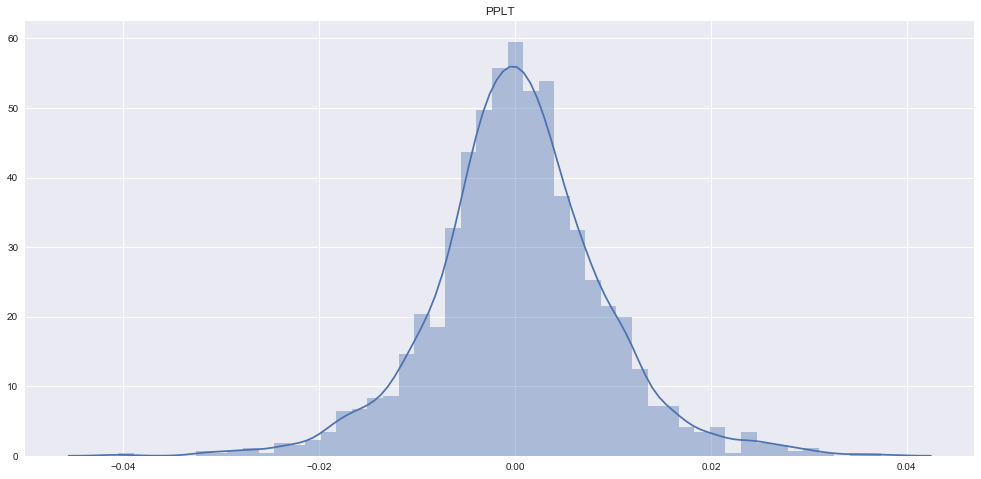

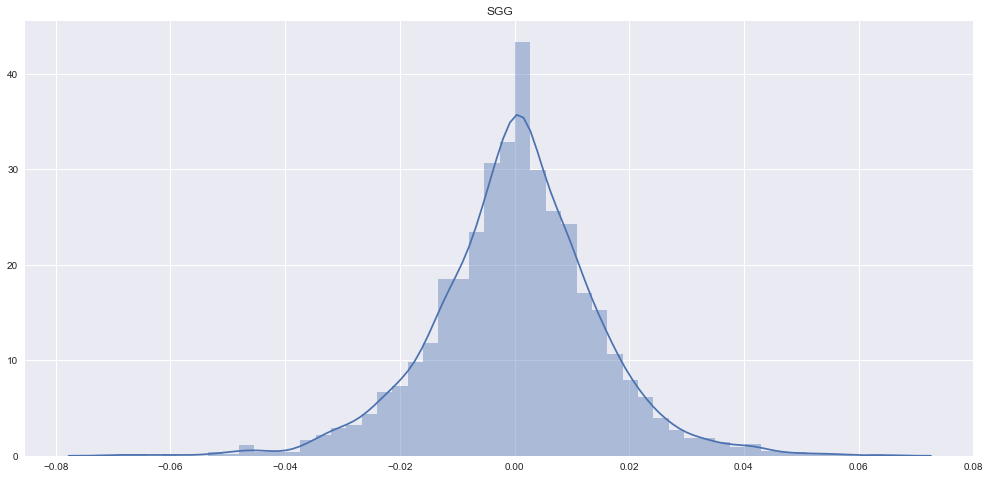

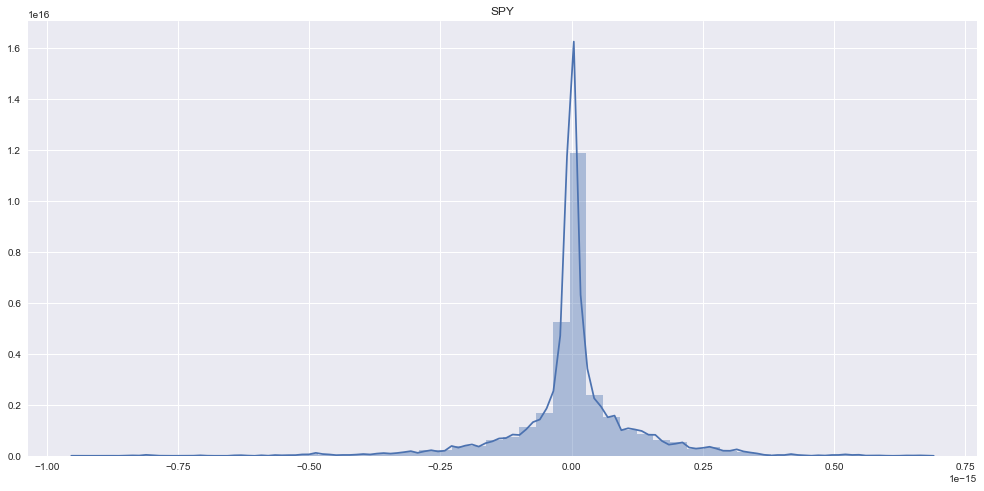

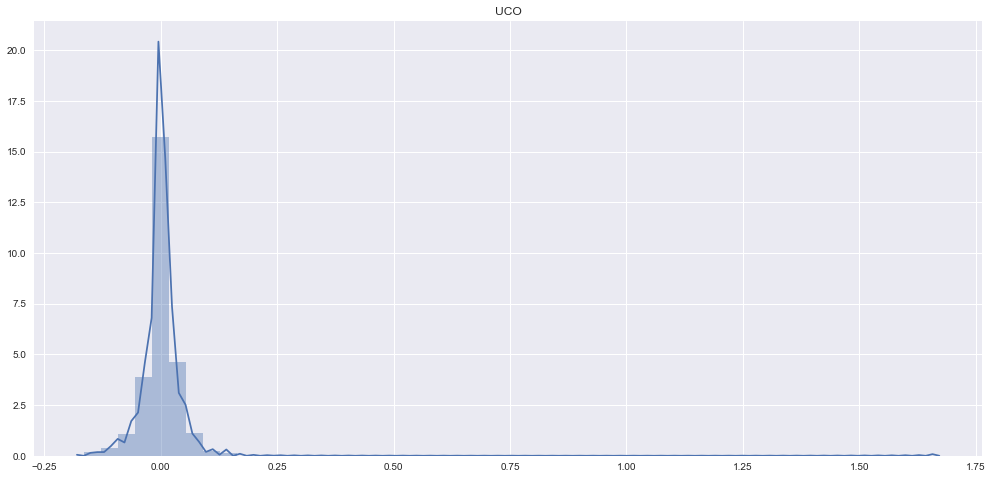

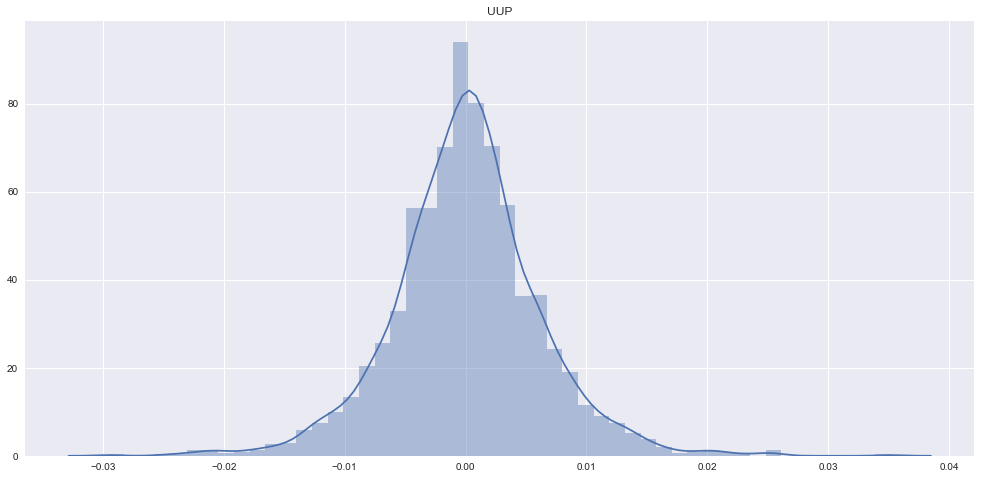

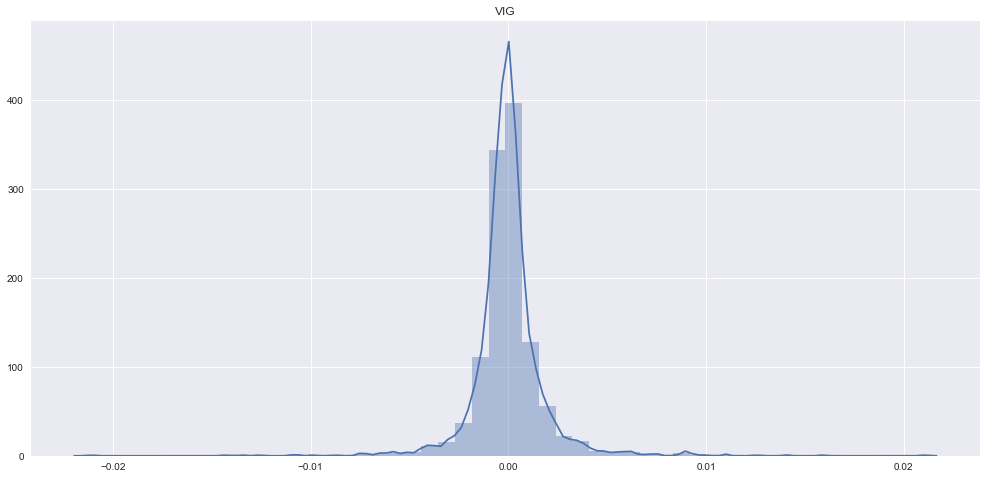

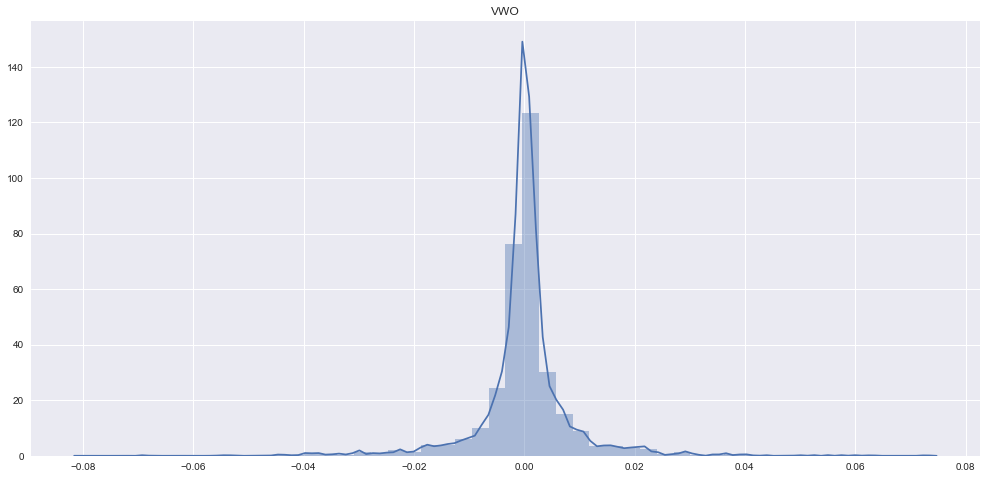

In [134]:
for key, grp in combined.groupby('ticker'):
    fig, ax = plt.subplots(figsize=(17, 8))
    sns.distplot((grp['ra_return'] - grp['log_return']).dropna(), ax=ax)
    plt.title(key)

In [7]:
category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

In [8]:
combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

In [50]:
combined.groupby('category_enc').mean()[['vol']].sort_values('vol')

,vol
category_enc,
0,0.005379
1,0.010676
3,0.013620
2,0.021701


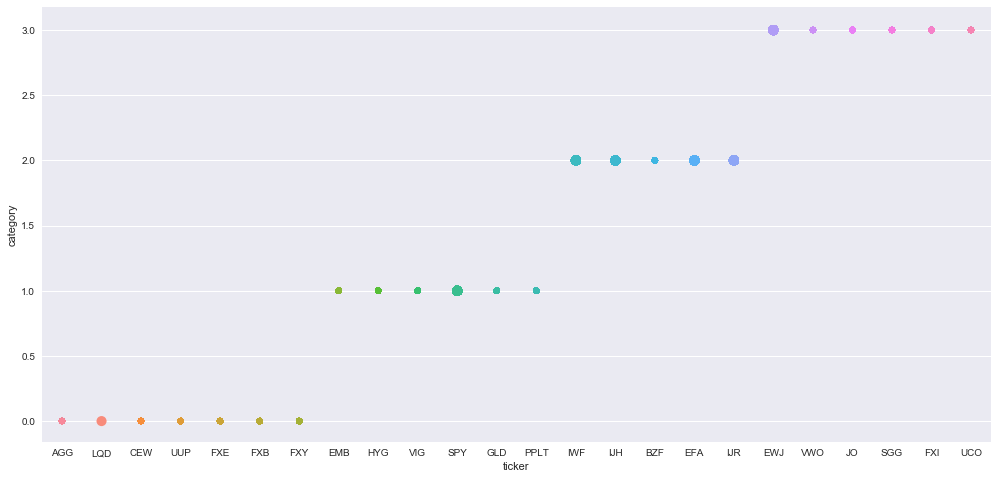

In [48]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.stripplot(x='ticker', y='category', data=combined.sort_values('vol'), size=combined.sort_values('vol')['vol']*2000, ax=ax)
# sns.stripplot(x='ticker', y='vol', data=combined.sort_values('vol'), ax=ax)

# Step 2:
## Build hierarchical regression model

In [11]:
combined = combined.dropna()

In [139]:
combined.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,pct_change,log_return,...,corr,beta,ra_return,ra_month_return,category,slow,value,category_enc,asset_type_enc,security_enc
Date,,,,,,,,,,,,,,,,,,,,,
2009-06-25,2009-06-25,162.51,163.7,162.47,163.509995,163.51,91200,FXB,0.009663,0.009617,...,0.386135,0.152738,0.001536,0.002107,2,185.462923,-0.118368,0,0,0
2009-06-26,2009-06-26,164.88,165.3,164.45,165.089996,165.09,53100,FXB,0.002544,0.002541,...,0.386721,0.152923,0.000456,-0.000006,2,185.440027,-0.109739,0,0,0
2009-06-29,2009-06-29,165.3,165.66,164.88,165.509995,165.51,87900,FXB,-0.006707,-0.006729,...,0.387014,0.153112,-0.000963,0.000708,2,185.417659,-0.107367,0,0,0
2009-06-30,2009-06-30,165.15,165.19,164.07,164.399994,164.4,55700,FXB,0.000791,0.000790,...,0.387180,0.153174,0.000188,0.003879,2,185.394603,-0.113243,0,0,0
2009-07-01,2009-07-01,165.02,165.27,164.47,164.529999,164.53,76900,FXB,-0.004802,-0.004813,...,0.388088,0.153412,-0.000671,0.006015,2,185.369894,-0.112423,0,0,0


In [147]:
sec_category_map.shape

(65,)

In [138]:
prices, combined = build_prices_dfs(tickers, 3)

slow_window = 252 * 3
for ticker in combined['ticker'].unique():
    combined.loc[combined['ticker'] == ticker, 'slow'] =\
    combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
        
combined['value'] = pd.to_numeric((combined['Close'] - combined['slow']) / combined['slow'])
combined = combined.dropna()
    

category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)

n_assets = len(asset_encodings)
n_categories = len(np.unique(sec_category_map))
n_securities = len(security_encodings)

train, test = train_test_split(combined, test_size=.3)

with pm.Model() as model:
    
    a_category_mu = pm.StudentT('a_category_mu', mu=0, sd=3, nu=1)
    a_category_sd = pm.HalfCauchy('a_category_sd', 2)
    
    a_category = pm.Normal('a_category', mu=a_category_mu, sd=a_category_sd, shape=n_categories)
    a_sec_sd = pm.Uniform('a_security_sd', 1, 5)
    
    a_sec = pm.Normal('a_security', mu=a_category[sec_category_map], sd=a_sec_sd, shape=n_securities)
    
#     b_category_mu = pm.Normal('b_category_mu', mu=0, sd=1)
#     b_category_sd = pm.HalfCauchy('b_category_sd', 2)
    
#     b_category = pm.Normal('b_category', mu=b_category_mu, sd=b_category_sd, shape=n_categories)
#     b_sec_sd = pm.HalfCauchy('b_security_sd', 2)
#     b_nu = pm.Uniform('b_nu', 1, 20)
#     b_mu = pm.Normal('b_mu', mu=0, sd=2)
#     b_sd = pm.Uniform('b_sd', 1, 3)
    b_sec = pm.Uniform('b_security', -1, 1, shape=n_securities)
    
    # Forward returns ~ Indicator * slope + intercept
    y_est = (train['value'].values * a_sec[train['security_enc'].values] + b_sec[train['security_enc'].values])
    epsilon = pm.Uniform('epsilon', 1, 5)
    nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=train['ra_month_return'].values)
    trace = pm.sample(500, init='advi', n_init=50000, step=pm.NUTS())

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,min_periods=22,center=False).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,min_periods=22,center=False).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,min_periods=22,center=False).sum()


ValueError: operands could not be broadcast together with shapes (24,) (65,) 

In [ ]:
pm.traceplot(trace);

In [35]:
def calc_prediction_helper(row):
    rt = row.value * np.mean(trace['a_security'][:, row.security_enc])
#     print("{} = {} * {} + {}".format(rt, row.momentum,
#                                      np.mean(trace['a_security'][:, row.security_enc]),
#                                     np.mean(trace['b_security'][:, row.security_enc])))
    a = (row.value * trace['a_security'][:, row.security_enc] + trace['b_security'][:, row.security_enc])
    return np.mean(a > 0)

In [36]:
test['prediction'] = test.apply(calc_prediction_helper, axis=1)

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


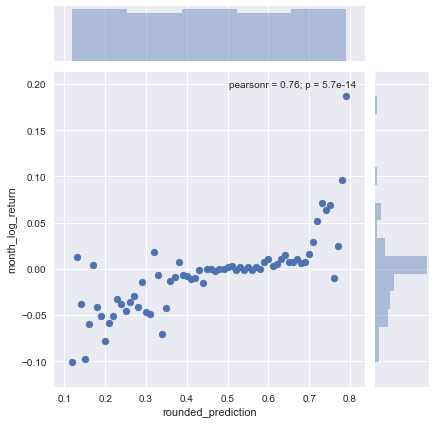

In [37]:
test['rounded_prediction'] = test['prediction'].round(2)
sns.jointplot(test.groupby('rounded_prediction').mean()['month_log_return'].index, test.groupby('rounded_prediction').mean()['month_log_return'])

In [66]:
for key, grp in test.groupby('category'):
    low, high = 1, 1
    rl = 0
    rs = 0
    p = 0
    for _p in np.arange(.05, .5, .05):
        _low, _high = grp['prediction'].quantile([_p, 1-_p])
        _rl = grp.loc[grp.prediction >= _high, 'month_log_return'].mean()
        _rs = grp.loc[grp.prediction <= _low, 'month_log_return'].mean()
        if (_rl - _rs) > (rl - rs):
            p = _p
            low = _low
            high = _high
            rl = _rl
            rs = _rs
    print("Long cutoff for category {}: {}".format(key, p))
    print("Short cutoff for category {}: {}".format(key, 1-p))
    print('Avg. return on long positions for category {}: {}'.format(key, grp.loc[grp.prediction >= high, 'month_log_return'].mean()))
    print('Avg. return on short positions for category {}: {}\n'.format(key, grp.loc[grp.prediction <= low, 'month_log_return'].mean()))

Long cutoff for category 0: 0.05
Short cutoff for category 0: 0.95
Avg. return on long positions for category 0: 0.0030217217916089353
Avg. return on short positions for category 0: -0.0062040674229338864

Long cutoff for category 1: 0.05
Short cutoff for category 1: 0.95
Avg. return on long positions for category 1: 0.009421249499211946
Avg. return on short positions for category 1: -0.014299644449773365

Long cutoff for category 2: 0.05
Short cutoff for category 2: 0.95
Avg. return on long positions for category 2: 0.012005407223808828
Avg. return on short positions for category 2: -0.017247404817038584

Long cutoff for category 3: 0.05
Short cutoff for category 3: 0.95
Avg. return on long positions for category 3: 0.041820517283530485
Avg. return on short positions for category 3: -0.036419097817606584



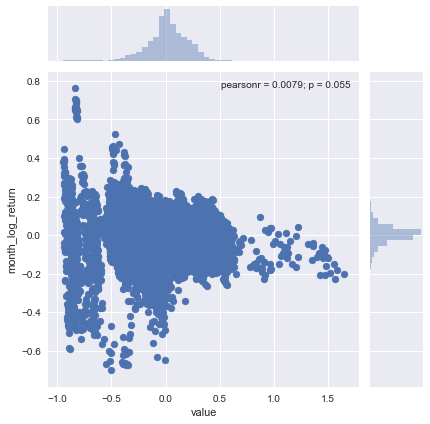

In [52]:
sns.jointplot('value', 'month_log_return', data=combined)

In [43]:
ticker_to_a = dict()
ticker_to_b = dict()
for t, i in security_encodings.items():
    ticker_to_a[t] = trace['a_security'][:, i]
    ticker_to_b[t] = trace['b_security'][:, i]

In [44]:
s = 'dict('
for t, a in ticker_to_a.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(FXB=[-0.117529122717, -0.249046090559, 0.0835313777098, -1.0004317977, 0.804739323101, 0.804739323101, -0.621775984408, -0.142164444083, 0.145005187038, -0.324436080572, -0.509623574534, -0.0499200016666, -0.0647467833468, 0.368881945661, 0.560150744573, 0.43847070539, 0.0791341369192, 0.386990032962, 0.0237141159045, 0.0516020066236, -0.814730510521, -0.297631192604, -0.628162394459, 0.0663460940759, 0.0663460940759, -0.14222259372, 0.189964446412, -0.0320377317395, 0.112640497307, 0.112640497307, -0.787502069725, -0.581426919329, -0.014507832582, -0.40783754441, -0.0178692921281, -0.0710553757842, -0.0710553757842, -0.0401560990211, 0.129167112157, -0.283022668806, -0.505207289733, -0.514856892993, 0.359000790555, 0.379265762094, -0.0107406459901, 0.0860382422933, 0.0860382422933, 0.253795505059, -0.605315112698, -0.37103256921, -0.358880163933, -0.071969178353, -0.619141309852, 0.391786320559, 0.391786320559, -0.150162104748, 0.00484988526611, 0.0401629474059, -0.543421552693, 

In [45]:
s = 'dict('
for t, a in ticker_to_b.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(FXB=[0.0140087865601, -0.0132280033946, -0.0131811127043, -0.029515006897, -0.00639430367918, -0.00639430367918, -0.0129984540226, -0.00721527252723, 0.00310704935612, -0.0188128406769, -0.0605714013094, 0.0186263126377, -0.00703022833592, 0.0151651659582, 0.0643215776265, 0.0207805498629, 0.0127947198295, 0.00283068556558, -0.00539388134334, -0.00687847889761, -0.0496410037138, -0.0914608058806, 0.0101440101304, 0.0539336282061, 0.0539336282061, 0.00857678893484, -0.00107522956182, -0.0149119392193, -0.00205604288397, -0.00205604288397, -0.0468720597523, -0.0437752339138, 0.041922795177, -0.0133902488882, 0.0107965843769, -0.0252679673487, -0.0252679673487, -0.0191507929918, 0.037705913252, -0.00229565385394, -0.0717704874205, -0.0536002212795, 0.0255202764935, 0.0136011195107, -0.0245403371221, 0.0299068170275, 0.0299068170275, -0.00360027711846, -0.0315272440188, -0.0262744441358, -0.023654661495, 0.00546216103157, -0.00646273084719, -0.0282164217154, -0.0282164217154, -0.00772

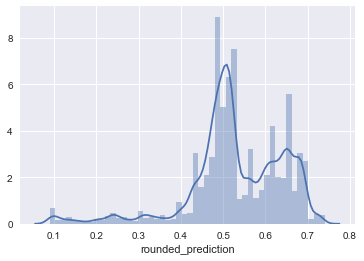

In [450]:
sns.distplot(combined['rounded_prediction'])
# sns.distplot(combined['month_log_return'])

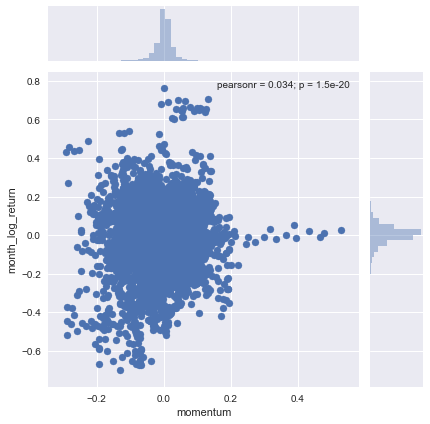

In [451]:
sns.jointplot('momentum', 'month_log_return', data=combined)

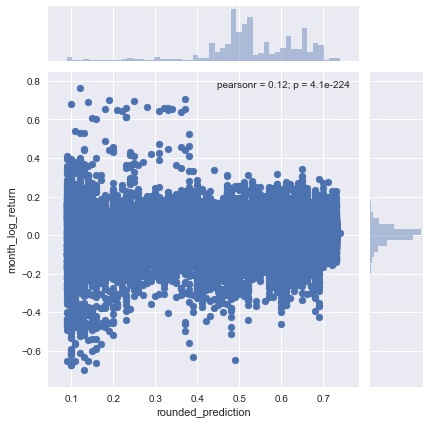

In [452]:
sns.jointplot('rounded_prediction', 'month_log_return', data=combined)

In [85]:
def eval_sharpe(returns, rf=.02):
    print("Mean returns: {}".format(np.mean(returns)))
    return (np.mean(returns)*252) / np.std(returns)

In [86]:
test['position'] = 0
low_p, high_p = .05, .95
for key, grp in test.groupby('category'):
    low, high = 1, 1
    sharpe = 0.
    p = 0
    for _p in np.arange(.05, .5, .05):
        _low, _high = grp['prediction'].quantile([_p, 1-_p])
        grp.loc[(grp.prediction >= _high), 'position'] = 1
        grp.loc[(grp.prediction <= _low), 'position'] = -1
        grp['bt_return'] = grp['log_return'] * grp['position']
        _sharpe = eval_sharpe(grp['bt_return'])
        if  _sharpe > sharpe:
            p = _p
            low = _low
            high = _high
            sharpe = _sharpe
    print('Sharpe for category {}: {}'.format(key, sharpe))
    print('Low p for category {}: {}'.format(key, p))
    print('High p for category {}: {}\n'.format(key, 1-p))

# test['bt_return'] = test['log_return'] * test['position']
# test['date'] = test.index

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Mean returns: 3.483330812224642e-05
Mean returns: 5.6424111677342416e-05
Mean returns: 5.33408689603327e-05
Mean returns: 6.217243992154742e-05
Mean returns: 0.00010405627439481714
Mean returns: 9.803658031518456e-05
Mean returns: 8.601859614278234e-05
Mean returns: 9.315254853420437e-05
Mean returns: 0.00011170024692224896
Sharpe for category 0: 6.510547286321262
Low p for category 0: 0.25
High p for category 0: 0.75

Mean returns: 1.461672960266511e-05
Mean returns: 4.189283772071809e-05
Mean returns: 5.824455134722747e-05
Mean returns: 0.00015359449411915248
Mean returns: 0.0001926039873517383
Mean returns: 0.00026313217024099325
Mean returns: 0.00035287966821035224
Mean returns: 0.00030854658697978784
Mean returns: 0.00030058844594858607
Sharpe for category 1: 10.289843038796821
Low p for category 1: 0.35000000000000003
High p for category 1: 0.6499999999999999

Mean returns: 9.093990056459733e-05
Mean returns: 8.825644981417528e-05
Mean returns: 2.7299512249502006e-05
Mean returns

In [73]:
print("Standard deviation of returns: {}".format(test['bt_return'].std()))
print("Standard deviation of benchmark returns: {}".format(test['log_return'].std()))

Standard deviation of returns: 0.0062795539460378655
Standard deviation of benchmark returns: 0.013830688271598368


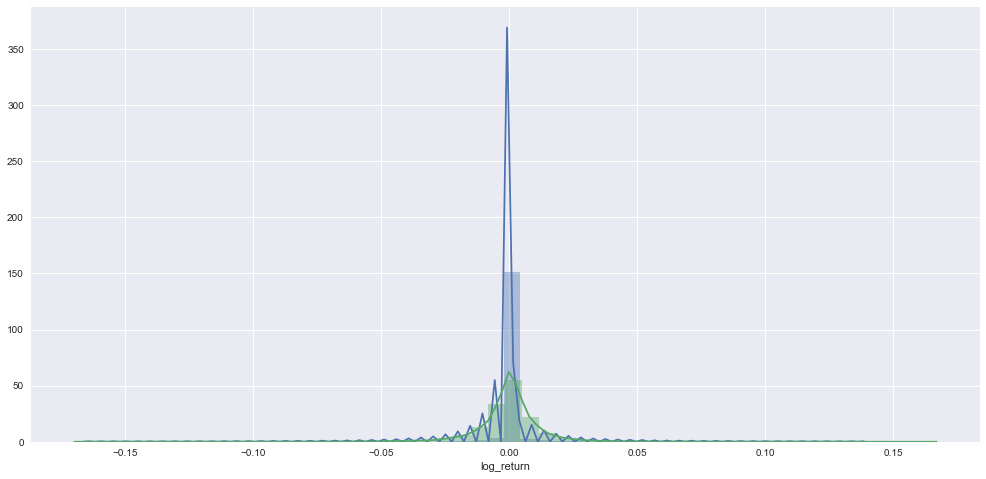

In [72]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.distplot(test['bt_return'], ax=ax)
sns.distplot(test['log_return'], ax=ax)

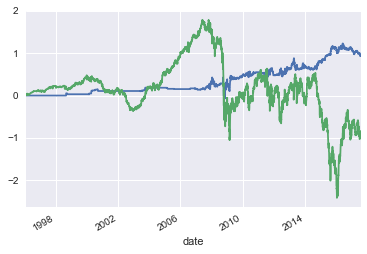

In [70]:
test.groupby('date').sum()['bt_return'].cumsum().plot()
test.groupby('date').sum()['log_return'].cumsum().plot()

In [318]:
# Calculate likelihood of positive forward month returns
a = (.02 * trace['a_security'][:, 10] + trace['b_security'][:, 10])
np.mean(a > 0)

0.98570000000000002

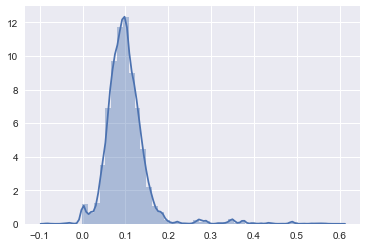

In [319]:
sns.distplot(trace['a_security'][:, 10])

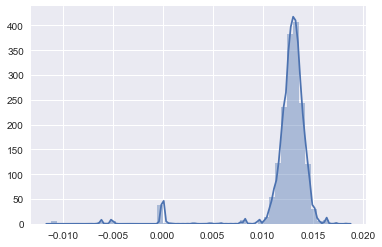

In [320]:
sns.distplot(trace['b_security'][:, 10])

In [327]:
np.mean(combined.loc[combined.security_enc==10, 'month_log_return'])

0.004074313702555441

In [168]:
security_encodings

{'AGG': 4,
 'EFA': 7,
 'EMB': 2,
 'HYG': 3,
 'IJH': 1,
 'IJR': 6,
 'IWF': 5,
 'LQD': 0,
 'SPY': 9,
 'VIG': 8,
 'VWO': 10}

In [326]:
combined.loc[:, ['momentum', 'month_log_return', 'prediction', 'security_enc']].sort_values('month_log_return')

,momentum,month_log_return,prediction,security_enc
Date,,,,
2008-09-25,-0.076662,-0.632523,0.93090,10
2008-09-24,-0.081097,-0.559686,0.91230,10
2008-09-22,-0.084976,-0.496025,0.89490,10
2008-09-25,-0.032976,-0.476216,0.97245,7
2008-09-19,-0.084898,-0.462080,0.89495,10
2008-09-25,-0.030162,-0.459665,0.97435,1
2008-09-23,-0.083429,-0.450323,0.90190,10
2008-09-26,-0.075104,-0.446928,0.93620,10
2008-09-25,-0.012921,-0.425113,0.98040,6


In [227]:
pd.DataFrame([1,2,3,4]).shift(1).rolling(3).mean()

,0
0,NaN
1,NaN
2,NaN
3,2.0
